## Video and Audio Content Analysis with Amazon Bedrock and Amazon Aurora PostgreSQL pgvector

This notebook demonstrates how to process video and audio content using [Amazon Bedrock](https://aws.amazon.com/bedrock/) to invoke [Amazon Titan Multimodal Embeddings G1 model](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html) for generating multimodal embeddings, [Amazon Transcribe](https://aws.amazon.com/transcribe/) for converting speech to text, and [Amazon Aurora PostgreSQL](https://docs.aws.amazon.com/AmazonRDS/latest/AuroraUserGuide/data-api.html) with pgvector for efficient vector storage and similarity search, you will build an app that understands both visual and audio content, enabling natural language queries to find specific moments in videos.

> Create Amazon Aurora PostgreSQL with this [Amazon CDK Stack](https://github.com/build-on-aws/langchain-embeddings/tree/main/create-aurora-pgvector)

![Diagram](data/video-embedding.png)

In [ ]:
#!pip install boto3
#!pip install json
#!pip install base64
#!pip install uuid
# or install requirements.txt

In [4]:
import boto3
import json
import os
from PIL import Image as PILImage
import random

region = os.environ.get("AWS_DEFAULT_REGION", "us-west-2")
ssm = boto3.client(service_name="ssm", region_name=region)
sns_client = boto3.client('stepfunctions')


# Default model settings
default_model_id = os.environ.get("DEFAULT_MODEL_ID", "amazon.titan-embed-image-v1")
default_embedding_dimmesion = os.environ.get("DEFAULT_EMBEDDING_DIMENSION", "1024")

## 2. Database Interface (AuroraPostgres Class)

An `AuroraPostgres` class that interacts with Amazon Aurora PostgreSQL [using RDS Data API](https://docs.aws.amazon.com/AmazonRDS/latest/AuroraUserGuide/data-api.html)

Code: [aurora_service.py](create_audio_video_helper/aurora_service.py)

In [5]:
from create_audio_video_helper import AuroraPostgres

## 3. Video Content Processing

A `VideoProcessor` class uses the [ffmpeg libavcodec library](https://ffmpeg.org/) to proccess the audio and create frames. 

The class is set to process frames every 1 second, you can modify this by changing the FPS value in command.

Code: [video_processor.py](create_audio_video_helper/video_processor.py)

## 6. Embedding Generation

Generate Embeddings for each extracted frame. Embeddins are created with the Amazon Titan Multimodal Embeddings G1 model using Amazon Bedrock Invoke Model API. 

Code: [embedding_generation.py](create_audio_video_helper/embedding_generation.py)


In [6]:
from create_audio_video_helper import EmbeddingGeneration

### Configuration
The system uses environment variables and AWS Systems Manager Parameter Store for configuration:

**DEFAULT_MODEL_ID:** Bedrock model ID (default: "amazon.titan-embed-image-v1")

**DEFAULT_EMBEDDING_DIMENSION:** Embedding dimension (default: "1024")

In [7]:

def get_ssm_parameter(name):
    response = ssm.get_parameter(Name=name, WithDecryption=True)
    return response["Parameter"]["Value"]



In [19]:
# Get Data from environment variables, never share secrets!

cluster_arn = get_ssm_parameter("/videopgvector/cluster_arn")
credentials_arn = get_ssm_parameter("/videopgvector/secret_arn")
table_name = get_ssm_parameter("/videopgvector/video_table_name")
api_url = get_ssm_parameter("/videopgvector/api_retrieve")
bucket_name = get_ssm_parameter("/videopgvector/bucket_name")
state_machine_arn = get_ssm_parameter("/videopgvector/state_machine_arn")

In [15]:
print(credentials_arn)

arn:aws:secretsmanager:us-west-2:147997153889:secret:bedrockSecretF820124E-AGCQt1M3MOCb-clPyTi


In [21]:
# Initialize Aurora PostgreSQL client
aurora = AuroraPostgres(cluster_arn, table_name, credentials_arn,region)

In [22]:
# Verify Aurora Cluster conectivity:
aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":290}]'}

In [23]:
embedding_generation = EmbeddingGeneration(region,default_model_id,default_embedding_dimmesion)

In [24]:
aurora.execute_statement("select count(*) from bedrock_integration.knowledge_bases")

{'numberOfRecordsUpdated': 0, 'formattedRecords': '[{"count":290}]'}

In [25]:
s3_client = boto3.client('s3')
base_path = "images/"

def download_file(base_path,bucket, key, filename):
    print("Download file from s3://{}{}".format(bucket,key))
    with open(base_path+filename, "wb") as data:
        s3_client.download_fileobj(bucket, key, data)
    print("Download file from s3://{}{}".format(bucket,key))
    return True

def read_image_from_s3(s3_key):
    parts = s3_key.split('s3://')[-1].split('/', 1)
    bucket_name = parts[0]
    image_key = parts[1]
    try:
        response = s3_client.get_object(Bucket=bucket_name, Key=image_key)
        image_data = response['Body'].read()
        return image_data
    except Exception as e:
        print(f'Error reading image from {s3_key}: {str(e)}')
        raise

# Upload Video to Amazon S3 bucket
def upload_file_to_s3 (video_path,bucket_name,s3_key):
    s3_client.upload_file(video_path, bucket_name,s3_key)
    print("Upload successful!")



In [ ]:
video_path = "<your-video-path>"
s3_key = f"video/{video_path}"
upload_file_to_s3 (video_path,bucket_name,s3_key)

### Check the status of the Step Functions workflow processing your video

In [26]:
response = sns_client.describe_state_machine(
    stateMachineArn=state_machine_arn
)

In [27]:
response = sns_client.list_executions(
    stateMachineArn=state_machine_arn,
    maxResults=12
)
response['executions'][0]

{'executionArn': 'arn:aws:states:us-west-2:147997153889:execution:wfVideoProcessingWorkflow09A1C915-6DEAEaqvOtSK:s3-trigger-1748361980-dev315',
 'stateMachineArn': 'arn:aws:states:us-west-2:147997153889:stateMachine:wfVideoProcessingWorkflow09A1C915-6DEAEaqvOtSK',
 'name': 's3-trigger-1748361980-dev315',
 'status': 'SUCCEEDED',
 'startDate': datetime.datetime(2025, 5, 27, 12, 6, 21, 115000, tzinfo=tzlocal()),
 'stopDate': datetime.datetime(2025, 5, 27, 15, 12, 12, 963000, tzinfo=tzlocal()),
 'redriveCount': 0}

## Similarity Search

Implements functions for:
- `retrieve()`: Performs similarity searches in the database and displays results
- `aurora.similarity_search()`: Executes the vector similarity search in the database
- `get_embeddings()`: Generates embeddings for the search query

In [28]:
from IPython.display import display

def retrieve(search_query, how="cosine", k=5):
    search_vector = embedding_generation.get_embeddings(search_query)
    
    result = aurora.similarity_search(search_vector,how=how, k=k)
    rows = json.loads(result.get("formattedRecords"))
    for row in rows:
        metric = "similarity" if how == "cosine" else "distance"
        metric_value = row.get(metric)
        if row.get("content_type") == "text":
            print("row: ", row)
            print (f"text:\n{row.get('chunks')}\n{metric}:{metric_value}\nmetadata:{row.get('metadata')}\n")
        if row.get("content_type") == "image":
            print(row)
            sourceurl = row.get('sourceurl')
            print(sourceurl)
            bucket_name = sourceurl.split("/")[2] 
            key = sourceurl.replace("s3://", "").replace(bucket_name,"").lstrip("/")
            filename = sourceurl.split("/")[-1] 
            print("bucket_name: ",bucket_name)
            print("key: ",key)
            print("filename: ",filename)
            download_file(base_path,bucket_name, key, filename)
            img = PILImage.open(base_path+filename)            
            print (f"Image:\n{row.get('sourceurl')}\n{metric}:{metric_value}\nmetadata:{row.get('metadata')}\n")
            display(img)
        del row["embedding"]
        del row["id"]

    return rows

I tested the notebook with my AWS re:Invent 2024 sesion [AI self-service support with knowledge retrieval using PostgreSQL](https://www.youtube.com/watch?v=fpi3awGakyg?trk=fccf147c-636d-45bf-bf0a-7ab087d5691a&sc_channel=video). 

I ask for Aurora and it brings me images and texts where it mentions:

![Diagram](data/cosine.png)

```bash
text:
memory . A place where all the information is stored and can easily be retrievable , and that's where the vector database comes in . This is the the first building block . And a vector database stores and retrieves data in the form of vector embeddeds or mathematical representations . This allows us to find similarities between data rather than relying on the exact keyword match that is what usually happens up to today . This is essential for systems like retrieval ofmented generation or RAC , which combines external knowledge with the AI response to deliver those accurate and context aware response . And by the way , I think yesterday we announced the re-rank API for RAC . So now your rack applications , you can score and it will prioritize those documents that have the most accurate information . So at the end will be even faster and cheaper building rack . We're gonna use Amazon Aurora postgrade SQL with vector support that will give us a scalable and fully managed solution for our AI tasks .
similarity:0.5754164493071239
metadata:{"speaker":"spk_0","second":321}
```


{'id': 'f0865061-00e1-4884-acf0-c0c534fe1ad7', 'embedding': '[0.019033147,0.055527896,-0.03859014,-0.0014078417,0.009778498,-0.024795476,-0.034923207,0.005849637,0.022525467,0.048543256,-0.014405822,0.0109135015,0.019993534,0.0013205337,0.012048506,0.046447862,-0.039463222,-0.034573972,0.025319325,-0.0024118838,-0.002018998,-0.015977366,0.055178665,-0.022176236,0.050289415,-0.0316055,0.034923207,-0.032303967,0.048892487,-0.0034268396,0.009210995,0.006940987,-0.0043435735,0.025319325,0.0024773648,-0.05832175,0.044527087,-0.01676314,-0.012572354,0.015104286,0.02811318,0.008861763,-0.043304775,0.05063865,-0.047146328,0.04173323,0.025843171,-0.04435247,0.039637838,0.016326599,0.019033147,0.00093310437,0.012135814,0.055527896,-0.0034704935,0.015628135,-0.0316055,-0.017461604,0.0023791434,0.006984641,0.016850447,-0.08591109,0.009691189,0.051686343,-0.0056313667,0.040336303,-0.06600486,0.051686343,-0.008206953,-0.01012773,0.015016979,-0.013707358,-0.04382862,-0.019731611,-0.048892487,0.003514

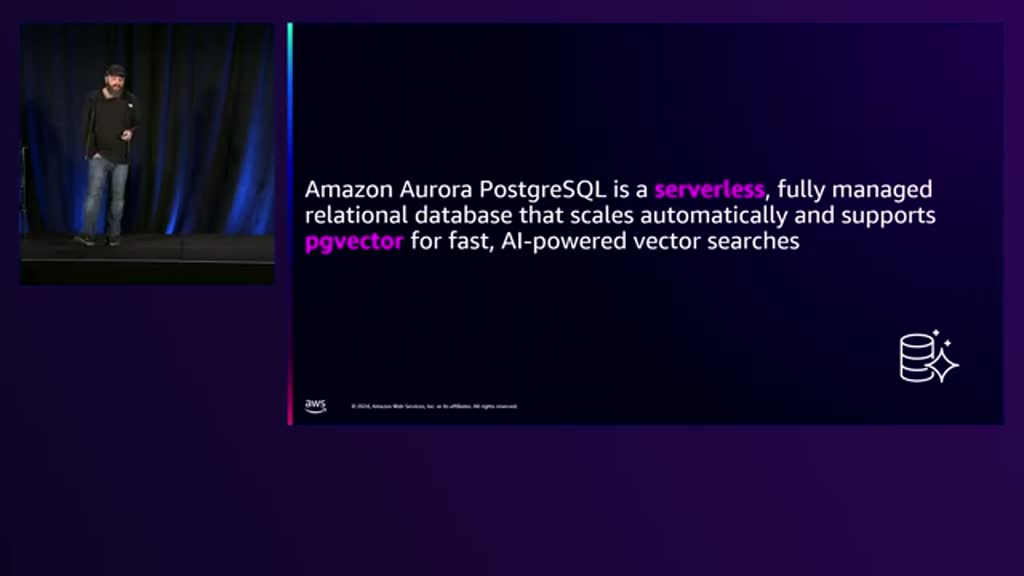

{'id': '6a374a4c-5ed3-43d4-bacc-cd9be8efef85', 'embedding': '[0.019033147,0.055527896,-0.03859014,-0.0014078417,0.009778498,-0.024795476,-0.034923207,0.005849637,0.022525467,0.048543256,-0.014405822,0.0109135015,0.019993534,0.0013205337,0.012048506,0.046447862,-0.039463222,-0.034573972,0.025319325,-0.0024118838,-0.002018998,-0.015977366,0.055178665,-0.022176236,0.050289415,-0.0316055,0.034923207,-0.032303967,0.048892487,-0.0034268396,0.009210995,0.006940987,-0.0043435735,0.025319325,0.0024773648,-0.05832175,0.044527087,-0.01676314,-0.012572354,0.015104286,0.02811318,0.008861763,-0.043304775,0.05063865,-0.047146328,0.04173323,0.025843171,-0.04435247,0.039637838,0.016326599,0.019033147,0.00093310437,0.012135814,0.055527896,-0.0034704935,0.015628135,-0.0316055,-0.017461604,0.0023791434,0.006984641,0.016850447,-0.08591109,0.009691189,0.051686343,-0.0056313667,0.040336303,-0.06600486,0.051686343,-0.008206953,-0.01012773,0.015016979,-0.013707358,-0.04382862,-0.019731611,-0.048892487,0.003514

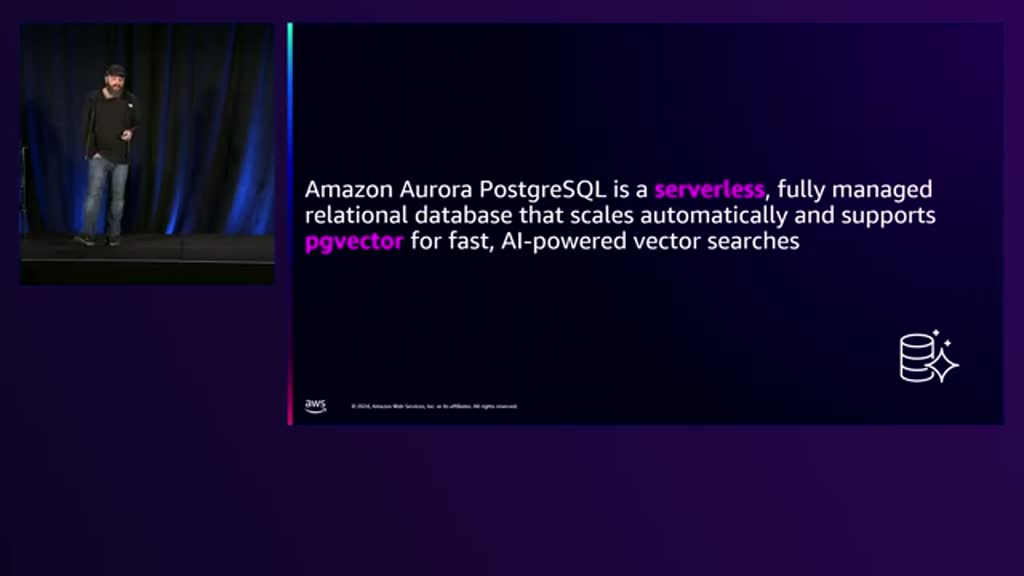

{'id': 'b09cc1bd-c93f-468f-8cf8-fddda0fb611c', 'embedding': '[0.048364643,0.03699534,-0.021836275,-0.0050304644,0.0010771509,-0.026167437,-0.024001855,0.011639997,0.024001855,0.061719056,-0.04403348,-0.029596273,0.029235343,0.006180929,0.00089104637,0.06424557,-0.02346046,0.0025941855,0.021204647,0.010918138,0.0025377902,-0.058831617,0.020031624,-0.04295069,0.049086504,-0.03699534,0.03591255,0.016512554,0.045296736,-0.025986971,0.0019512787,-0.0029099993,-0.0646065,0.040604644,0.0021091856,-0.025626041,0.037536737,-0.0002890261,-0.014527439,0.012271626,0.007850231,-0.006902789,-0.010421858,0.0067674406,-0.035371155,0.054861385,-0.009564649,-0.024182322,0.049086504,-0.007895348,-0.0053913943,0.016783252,0.024543252,0.01741488,0.004849999,0.009564649,-0.036093015,-0.047642782,0.031400923,-0.030859528,-0.0128130205,-0.07868277,0.05053022,0.00047654062,0.0128130205,0.023821391,-0.10827905,0.031039994,0.007850231,0.0017595346,-0.010512091,-0.0048725572,-0.06532836,-0.03789767,-0.032483716,0

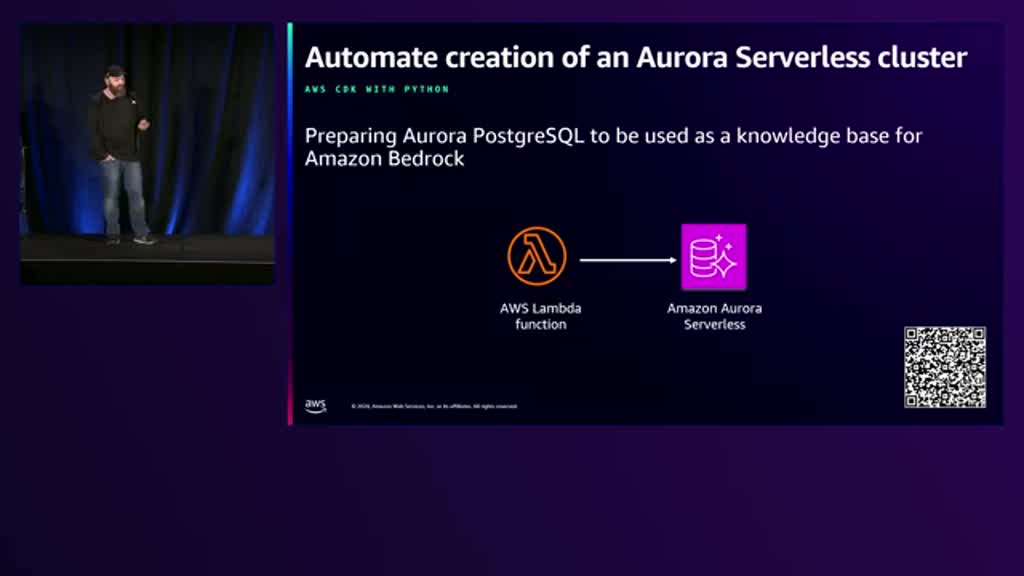

{'id': '8582157a-67af-4f15-bcdd-de00f942cc0f', 'embedding': '[0.048364643,0.03699534,-0.021836275,-0.0050304644,0.0010771509,-0.026167437,-0.024001855,0.011639997,0.024001855,0.061719056,-0.04403348,-0.029596273,0.029235343,0.006180929,0.00089104637,0.06424557,-0.02346046,0.0025941855,0.021204647,0.010918138,0.0025377902,-0.058831617,0.020031624,-0.04295069,0.049086504,-0.03699534,0.03591255,0.016512554,0.045296736,-0.025986971,0.0019512787,-0.0029099993,-0.0646065,0.040604644,0.0021091856,-0.025626041,0.037536737,-0.0002890261,-0.014527439,0.012271626,0.007850231,-0.006902789,-0.010421858,0.0067674406,-0.035371155,0.054861385,-0.009564649,-0.024182322,0.049086504,-0.007895348,-0.0053913943,0.016783252,0.024543252,0.01741488,0.004849999,0.009564649,-0.036093015,-0.047642782,0.031400923,-0.030859528,-0.0128130205,-0.07868277,0.05053022,0.00047654062,0.0128130205,0.023821391,-0.10827905,0.031039994,0.007850231,0.0017595346,-0.010512091,-0.0048725572,-0.06532836,-0.03789767,-0.032483716,0

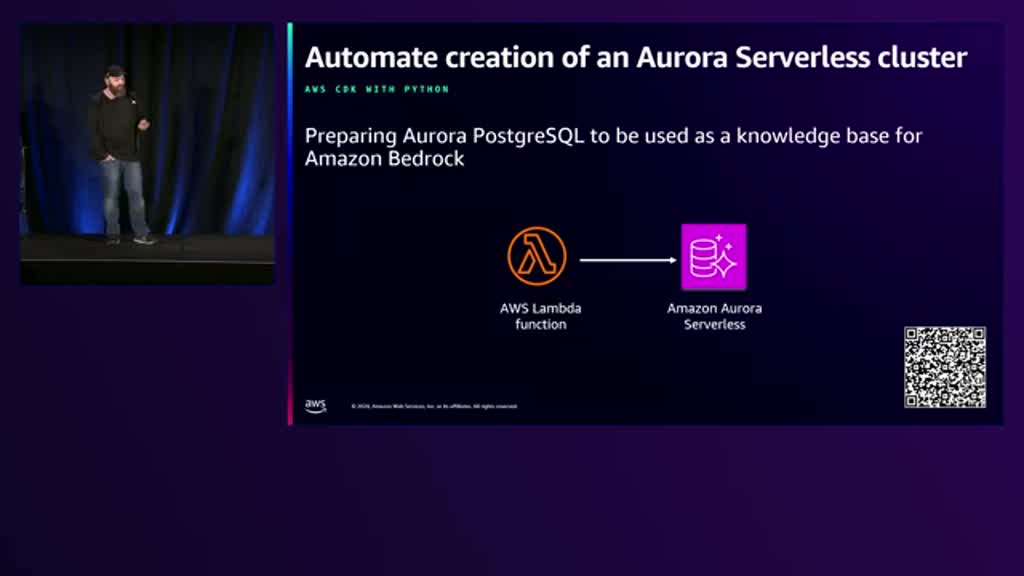

{'id': '073eac23-1d13-42fa-a57b-e6c9ab105d76', 'embedding': '[0.052231822,0.02143618,-0.037437838,-0.044080034,0.030644681,0.0070195943,-0.11835188,-0.030644681,0.009397199,0.029286051,0.032154273,-0.0026983926,0.033361945,-0.020983305,0.034569617,0.015322341,-0.026870705,0.025059197,0.0061138403,-0.01675645,0.022040017,0.047099214,0.13586313,-0.00032078792,0.012831517,-0.046193462,0.03894743,-0.027021665,0.08936774,-0.0016699842,-0.0076611703,-0.028229337,0.019096317,-0.0033777081,-0.003547537,-0.015322341,-0.0121522015,-0.04800497,0.014793985,0.031399477,0.04196661,-0.062798955,-0.030644681,0.023549607,-0.032909065,0.016379055,0.022643853,-0.023247689,0.050420314,-0.0028682214,-0.0070573343,0.0116238445,0.028531255,-0.04196661,-0.022794813,-0.008114047,-0.025512075,-0.007095074,0.009963295,-0.0116993245,-0.021738099,-0.03985318,0.04468387,-0.027625501,0.0335129,0.050118394,-0.056458674,0.053439494,-0.037437838,-0.074573755,-0.01683193,-0.049212642,-0.07789486,-0.068837315,-0.01803960

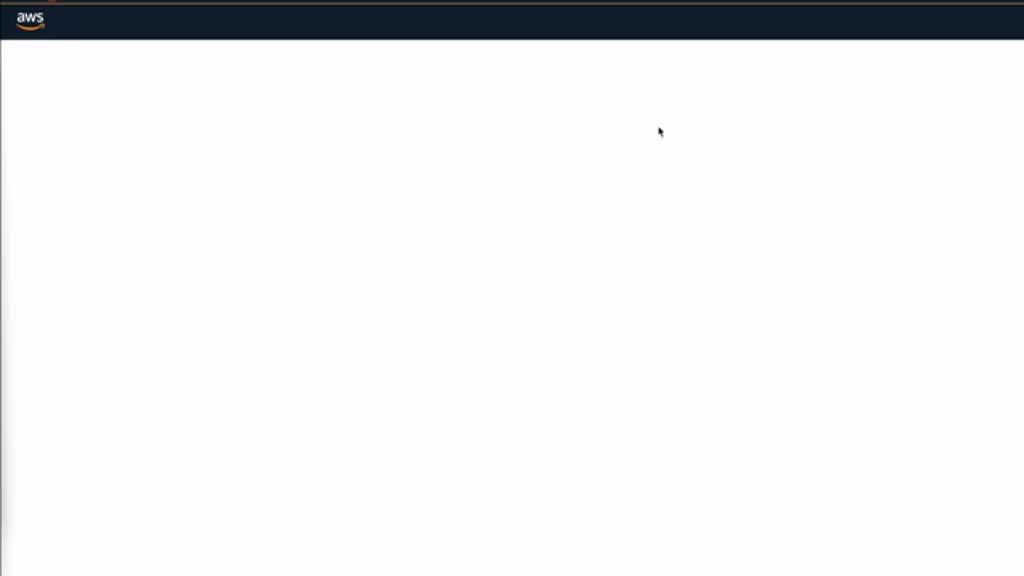

{'id': '95b7d974-21f2-4e62-b322-1c6176ef1082', 'embedding': '[0.052231822,0.02143618,-0.037437838,-0.044080034,0.030644681,0.0070195943,-0.11835188,-0.030644681,0.009397199,0.029286051,0.032154273,-0.0026983926,0.033361945,-0.020983305,0.034569617,0.015322341,-0.026870705,0.025059197,0.0061138403,-0.01675645,0.022040017,0.047099214,0.13586313,-0.00032078792,0.012831517,-0.046193462,0.03894743,-0.027021665,0.08936774,-0.0016699842,-0.0076611703,-0.028229337,0.019096317,-0.0033777081,-0.003547537,-0.015322341,-0.0121522015,-0.04800497,0.014793985,0.031399477,0.04196661,-0.062798955,-0.030644681,0.023549607,-0.032909065,0.016379055,0.022643853,-0.023247689,0.050420314,-0.0028682214,-0.0070573343,0.0116238445,0.028531255,-0.04196661,-0.022794813,-0.008114047,-0.025512075,-0.007095074,0.009963295,-0.0116993245,-0.021738099,-0.03985318,0.04468387,-0.027625501,0.0335129,0.050118394,-0.056458674,0.053439494,-0.037437838,-0.074573755,-0.01683193,-0.049212642,-0.07789486,-0.068837315,-0.01803960

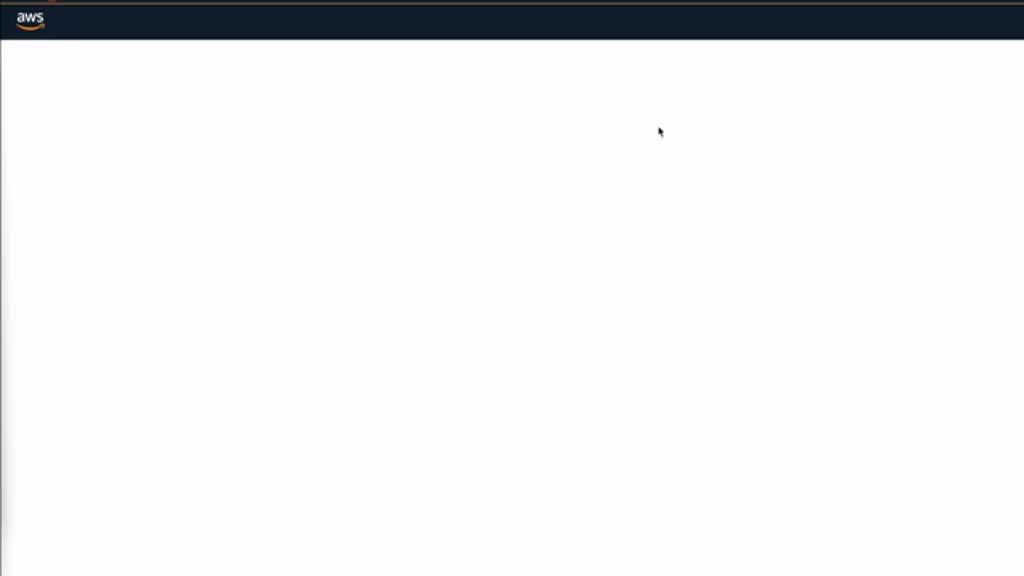

{'id': '5ecb5d02-6d42-464c-80e8-b4d168824dfc', 'embedding': '[0.025704015,0.03284402,-0.027274815,-0.037984822,0.029559618,0.0029452518,-0.10681446,-0.03541442,0.025846815,0.026846416,0.030844819,-0.007854004,0.03655682,-0.011281206,0.04969443,0.009424806,-0.019563612,0.020848813,0.009424806,-0.019420812,0.019992013,0.039127223,0.12852007,-0.021705613,0.032415617,-0.023419214,0.045981627,-0.03541442,0.08111045,-0.011138407,0.0029452518,-0.033843618,0.023276413,0.0076398044,-0.019420812,-0.01770721,0.0041947523,-0.04541043,0.037413623,0.040840823,0.039698422,-0.049123228,-0.028702816,0.029131217,-0.021562813,0.014137208,0.0124236075,-0.029559618,0.0062475037,-0.015850808,0.01927801,0.010781406,0.026703615,-0.03655682,-0.009424806,0.0041233525,-0.025704015,-0.008960705,0.020277612,-0.030416418,-0.027988816,-0.033843618,0.043696824,-0.0077469046,0.042268824,0.03441482,-0.031701617,0.041126423,-0.041412026,-0.06368884,-0.026275216,-0.05055123,-0.05055123,-0.05140803,-0.021991212,0.00496230

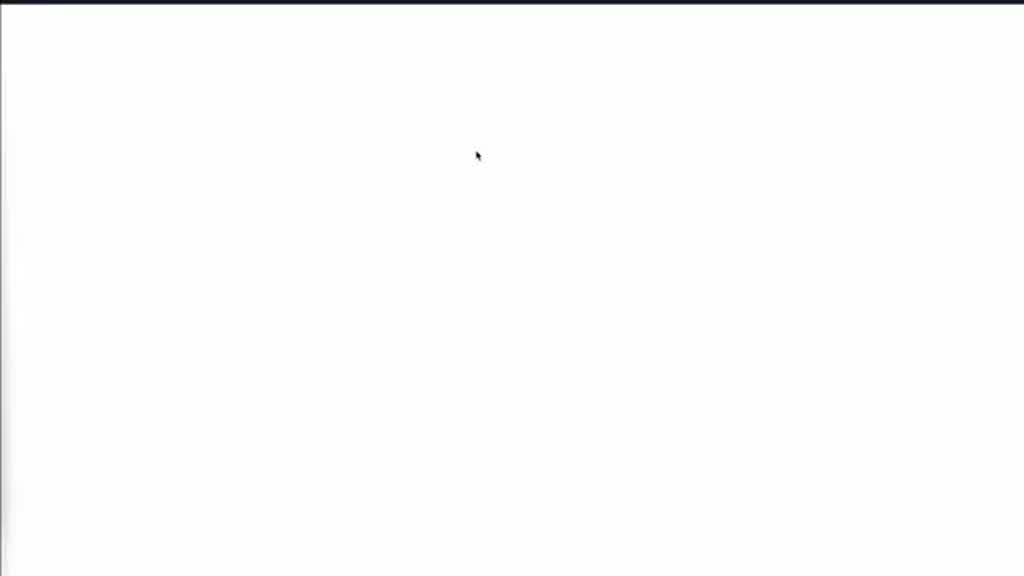

{'id': '4de89fcb-2b82-4a10-8ab1-4749c89717ea', 'embedding': '[0.025704015,0.03284402,-0.027274815,-0.037984822,0.029559618,0.0029452518,-0.10681446,-0.03541442,0.025846815,0.026846416,0.030844819,-0.007854004,0.03655682,-0.011281206,0.04969443,0.009424806,-0.019563612,0.020848813,0.009424806,-0.019420812,0.019992013,0.039127223,0.12852007,-0.021705613,0.032415617,-0.023419214,0.045981627,-0.03541442,0.08111045,-0.011138407,0.0029452518,-0.033843618,0.023276413,0.0076398044,-0.019420812,-0.01770721,0.0041947523,-0.04541043,0.037413623,0.040840823,0.039698422,-0.049123228,-0.028702816,0.029131217,-0.021562813,0.014137208,0.0124236075,-0.029559618,0.0062475037,-0.015850808,0.01927801,0.010781406,0.026703615,-0.03655682,-0.009424806,0.0041233525,-0.025704015,-0.008960705,0.020277612,-0.030416418,-0.027988816,-0.033843618,0.043696824,-0.0077469046,0.042268824,0.03441482,-0.031701617,0.041126423,-0.041412026,-0.06368884,-0.026275216,-0.05055123,-0.05055123,-0.05140803,-0.021991212,0.00496230

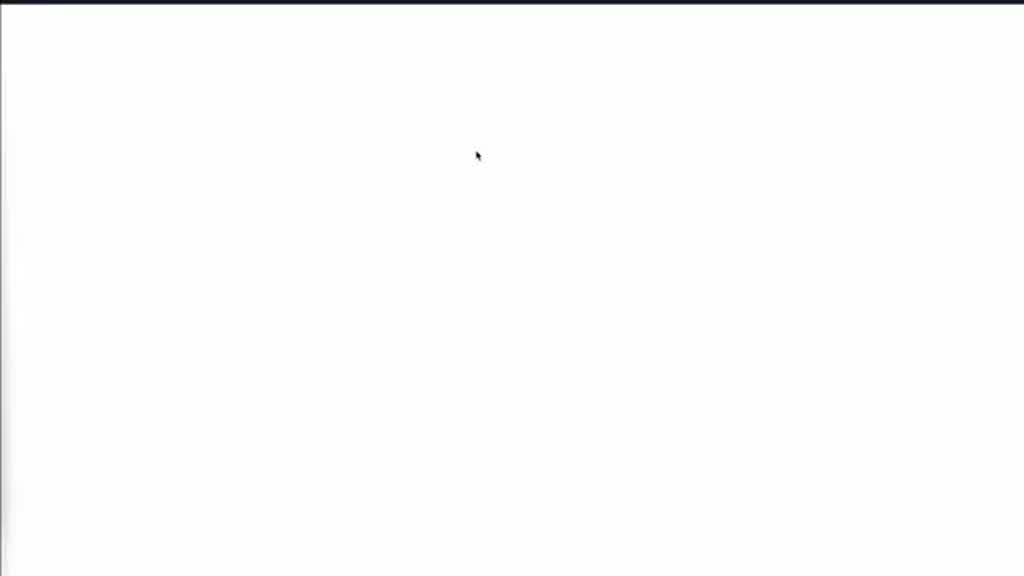

{'id': '1aa806ab-c735-4bf0-a5dd-76422c1cef89', 'embedding': '[0.059748773,0.057627514,-0.014937193,-0.015732665,0.053738542,0.0039110696,-0.024924783,0.0114901485,-0.0009501469,0.0558598,0.013788179,-0.012727549,0.04101099,-0.0022096438,-0.011269184,0.045076735,-0.02333384,0.021566125,-0.009103733,0.0085734185,0.004308806,-0.024040926,0.08591095,0.00583346,0.030758243,-0.016351365,0.042071622,-0.0052147596,0.021831281,-0.045076735,-0.009722433,0.0019002937,-0.0053031454,0.029874386,-0.011313377,-0.0707086,0.024217697,-0.014053335,-0.008661804,0.010827255,0.042778708,0.01643975,-0.01767715,0.021124195,-0.032349188,0.034293674,0.008352454,-0.06187003,0.044723194,0.04914248,0.029874386,0.02439447,0.028813757,-0.001408648,0.0024416565,-0.014230107,0.023687383,0.008971155,0.020328725,-0.01228562,0.0008728094,-0.06434483,0.022980297,-0.016086208,-0.007866332,0.040303905,-0.072829865,0.018826166,-0.010252748,-0.024040926,-0.027576357,-0.03252596,-0.08520387,-0.05126374,-0.018030694,0.01573266

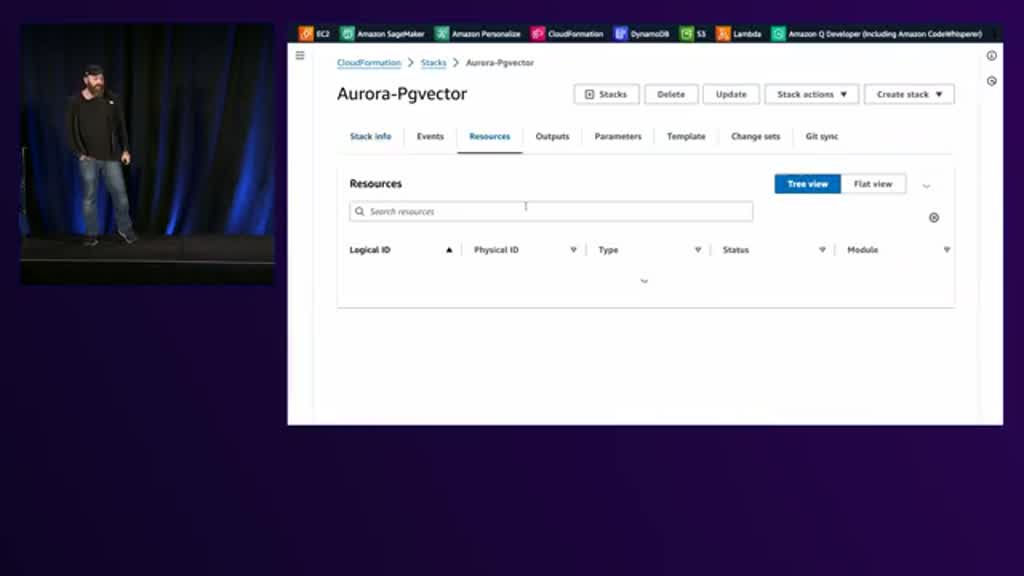

{'id': 'fc794c02-f43f-4cd7-aa96-f6cf5557886d', 'embedding': '[0.059748773,0.057627514,-0.014937193,-0.015732665,0.053738542,0.0039110696,-0.024924783,0.0114901485,-0.0009501469,0.0558598,0.013788179,-0.012727549,0.04101099,-0.0022096438,-0.011269184,0.045076735,-0.02333384,0.021566125,-0.009103733,0.0085734185,0.004308806,-0.024040926,0.08591095,0.00583346,0.030758243,-0.016351365,0.042071622,-0.0052147596,0.021831281,-0.045076735,-0.009722433,0.0019002937,-0.0053031454,0.029874386,-0.011313377,-0.0707086,0.024217697,-0.014053335,-0.008661804,0.010827255,0.042778708,0.01643975,-0.01767715,0.021124195,-0.032349188,0.034293674,0.008352454,-0.06187003,0.044723194,0.04914248,0.029874386,0.02439447,0.028813757,-0.001408648,0.0024416565,-0.014230107,0.023687383,0.008971155,0.020328725,-0.01228562,0.0008728094,-0.06434483,0.022980297,-0.016086208,-0.007866332,0.040303905,-0.072829865,0.018826166,-0.010252748,-0.024040926,-0.027576357,-0.03252596,-0.08520387,-0.05126374,-0.018030694,0.01573266

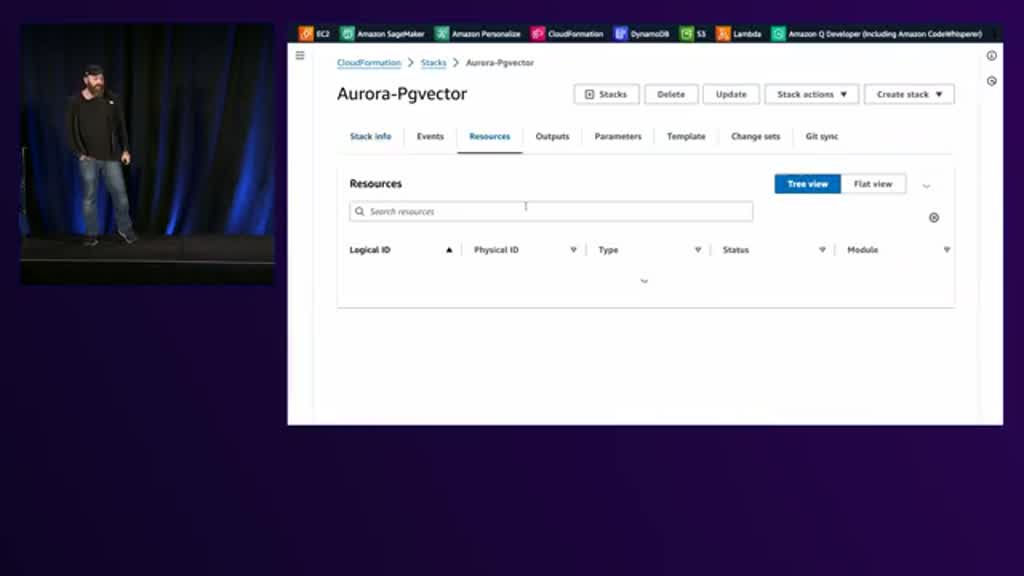

In [29]:
search_query = "aurora"
docs = retrieve(search_query, how="cosine", k=10)

In [ ]:
search_vector = embedding_generation.get_embeddings(search_query)
result = aurora.similarity_search(search_vector,how="cosine", k=3)

In [ ]:
rows = json.loads(result.get("formattedRecords"))

In [ ]:
search_query = "elizabeth"
docs = retrieve(search_query, how="l2", k=10)

## RAG Implementation

Finally, the notebook implements a complete RAG system:
- `CustomMultimodalRetriever`: A custom retriever class that extends BaseRetriever
- `_get_relevant_documents()`: Core retrieval method that finds similar content
- `image_content_block()`: Formats image content for LLM consumption
- `text_content_block()`: Formats text content for LLM consumption
- `parse_docs_for_context()`: Processes documents for context (text and images)
- `ThinkingLLM`: Uses an LLM to answer questions based on retrieved content

> Based on https://github.com/langchain-ai/langchain/blob/master/docs/docs/how_to/custom_retriever.ipynb



In [ ]:
from typing import List

from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.retrievers import BaseRetriever

class CustomMultimodalRetriever(BaseRetriever):
    """A retriever that contains the top k documents that contain the user query.
    query could be text or image_bytes
    """
    k: int
    """Number of top results to return"""
    how: str
    """How to calculate the similarity between the query and the documents."""

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        """Sync implementations for retriever."""
        search_vector = embedding_generation.get_embeddings(query)
        result = aurora.similarity_search(search_vector, how=self.how, k=self.k)
        rows = json.loads(result.get("formattedRecords"))

        matching_documents = []

        for row in rows:
            document_kwargs = dict(
                metadata=dict(**json.loads(row.get("metadata")), content_type = row.get("content_type"), source=row.get("sourceurl")))
            
            if self.how == "cosine":
                document_kwargs["similarity"] = row.get("similarity")
            elif self.how == "l2":
                document_kwargs["distance"] = row.get("distance")

            if row.get("content_type") == "text":
                matching_documents.append( Document( page_content=row.get("chunks"), **document_kwargs ))
            if row.get("content_type") == "image":
                matching_documents.append( Document( page_content=row.get("source"),**document_kwargs ))

        return matching_documents

In [ ]:
retriever = CustomMultimodalRetriever(how="cosine", k=20)

In [ ]:
query = "como funciona aurora"
docs = retriever.invoke(query)


In [ ]:
list(docs)

# Building the RAG 

In [ ]:
from typing import List, Dict
bedrock_runtime = boto3.client(service_name="bedrock-runtime", region_name=_region_name)


budget_tokens = 0
max_tokens = 1024
conversation: List[Dict] = []
reasoning_config = {"thinking": {"type": "enabled", "budget_tokens": budget_tokens}}

In [ ]:
def image_content_block(sourceurl):
    print("sourceurl: ",sourceurl)
    bucket_name = sourceurl.split("/")[2] 
    key = sourceurl.replace("s3://", "").replace(bucket_name,"").lstrip("/")
    filename = sourceurl.split("/")[-1] 
    print("bucket_name: ",bucket_name)
    print("key: ",key)
    print("filename: ",filename)
    image_bytes = read_image_from_s3(sourceurl)
    extension = filename.split('.')[-1]
    print (f"Including Image :{filename}")
    if extension == 'jpg':
        extension = 'jpeg'
    
    block = { "image": { "format": extension, "source": { "bytes": image_bytes}}}
    print(block)
    return block

def text_content_block(text):
    return { "text": text }

def parse_docs_for_context(docs):
    blocks = []
    for doc in docs:
        if doc.metadata.get('content_type') == "image":
            print(doc)
            blocks.append(image_content_block(doc.metadata.get('source')))
        else:
            print(doc)
            blocks.append(text_content_block(doc.page_content))
    return blocks

In [ ]:
def answer(model_id,system_prompt,content) -> str:
    """Get completion from Claude model based on conversation history.

    Returns:
        str: Model completion text
    """

    # Invoke model
    kwargs = dict(
        modelId=model_id,
        inferenceConfig=dict(maxTokens=max_tokens),
        messages=[
            {
                "role": "user",
                "content": content,
            }
        ],

    )

    kwargs["system"] = [{"text": system_prompt}]

    response = bedrock_runtime.converse(**kwargs)
    
    return response.get("output",{}).get("message",{}).get("content", [])
    


In [ ]:

system_prompt = """Answer the user's questions based on the below context. If the context has an image, indicate that it can be reviewed for further feedback.
If the context doesn't contain any relevant information to the question, don't make something up and just say "I don't know". (IF YOU MAKE SOMETHING UP BY YOUR OWN YOU WILL BE FIRED). For each statement in your response provide a [n] where n is the document number that provides the response. """
model_id = "us.amazon.nova-pro-v1:0"


In [ ]:
query = "<your-query>"
docs = retriever.invoke(query)
parsed_docs = parse_docs_for_context(docs)

In [ ]:
llm_response = answer(model_id,system_prompt,[text_content_block(f"question:{query}\n\nDocs:\n"), *parsed_docs])

In [ ]:
print(llm_response[0].get("text"))

In [ ]:
query = "<your-query>"
docs = retriever.invoke(query)
parsed_docs = parse_docs_for_context(docs)
llm_response = answer(model_id,system_prompt,[text_content_block(f"question:{query}\n\nDocs:\n"), *parsed_docs])
print(llm_response[0].get("text"))

# Query thought Amazon Lambda function

In [ ]:
import boto3
import json

In [ ]:

# Inicializar el cliente de Lambda
lambda_client = boto3.client('lambda', region_name="us-east-1")

# 1. Invocación Síncrona (RequestResponse)
def invoke_lambda_sync(function_name, payload):
    try:
        response = lambda_client.invoke(
        FunctionName=function_name, 
        InvocationType='RequestResponse',
        Payload=json.dumps(payload)
        )
        response_payload = json.loads(response['Payload'].read())
        return response_payload

    except Exception as e:
        print(f"Error invoking Lambda: {str(e)}")
        raise


In [ ]:
function_name = "<your-lambda>"

In [ ]:
payload = {
    "id": "<your-video-name>",
    "query": "<your-query>",
    "method":"retrieve_generate"
}

In [ ]:
response_payload = invoke_lambda_sync(function_name, payload)

In [ ]:
response_payload